In [10]:

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset for research/heart attack'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
# plt.style.use('white')
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Data Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Basic Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import time

#Metrics (Computation)
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import GridSearchCV

#Boosting Algorithms
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

#Neural Network Model
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")

In [12]:
data1=pd.read_csv("/content/drive/MyDrive/Research Dataset/heart attack/heart.csv")
data1.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


#Data Preprocessing

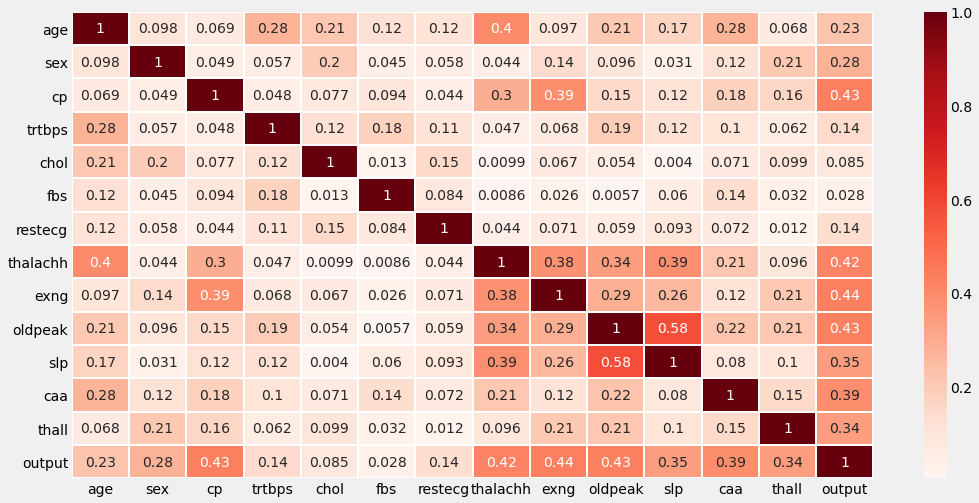

exng        0.436757
cp          0.433798
oldpeak     0.430696
thalachh    0.421741
caa         0.391724
slp         0.345877
thall       0.344029
sex         0.280937
age         0.225439
trtbps      0.144931
restecg     0.137230
chol        0.085239
fbs         0.028046
Name: output, dtype: float64


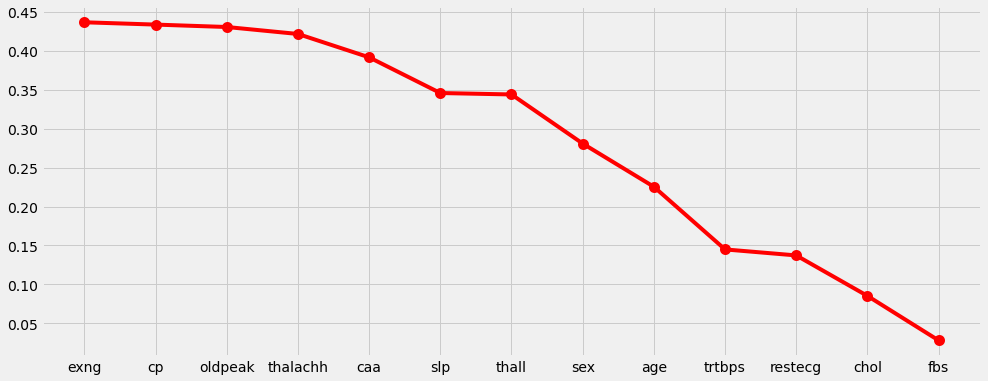

In [13]:
new_df=data1
plt.figure(figsize=(16,8))
corr=new_df.corr()
sns.heatmap(abs(corr),lw=1,annot=True,cmap="Reds")
plt.show()

C=abs(corr["output"]).sort_values(ascending=False)[1:]
print(C)
plt.figure(figsize=(15,6))
plt.plot(C.index,C,color="red")
plt.scatter(C.index,C,color="red",lw=5)
plt.show()

01. We can see that no column is highly correlated with the output, with a maximum correlation of 0.436757 for "exng" and a minimum correlation of 0.028046 for "fbs". Anyway, we will go ahead and use them all for our model.

02. Next, we have to check the data for outliners and treat them.
We will use the IQR (Inter-Quartile Range) method to detect outliners and then visualize them with the help of boxplots.

In [14]:
continuous_cols=["age","trtbps","chol","thalachh","oldpeak"]
continuous_data=data1[continuous_cols]

for k, v in continuous_data.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(data1)[0]
        print("Column {} outliers = {} => {}%".format(k,len(v_col),round((perc),3)))

Column age outliers = 0 => 0.0%
Column trtbps outliers = 13 => 4.29%
Column chol outliers = 5 => 1.65%
Column thalachh outliers = 1 => 0.33%
Column oldpeak outliers = 8 => 2.64%


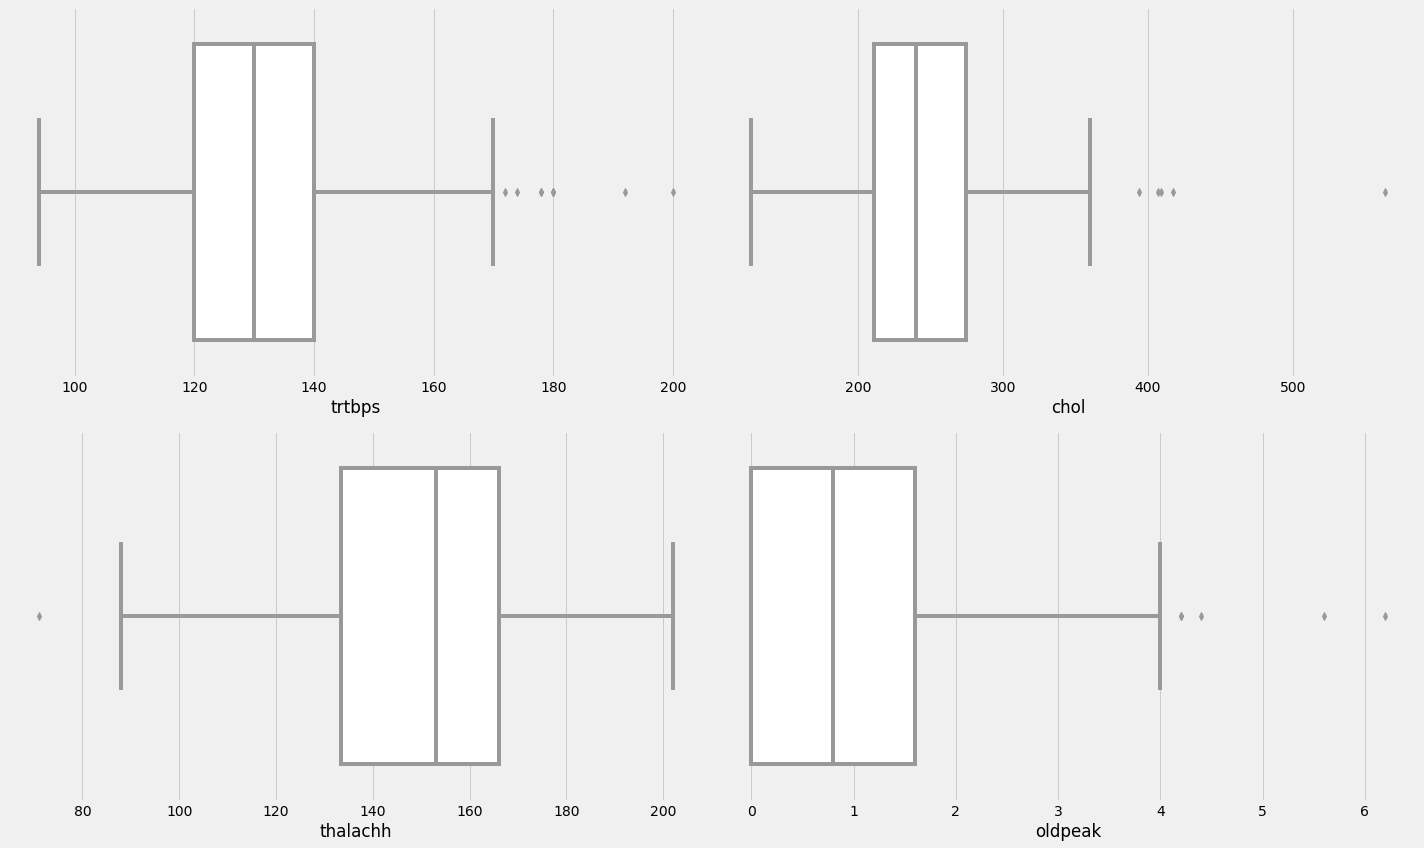

Outliners Present at position: 

trtbps: (array([  8, 101, 110, 152, 195, 203, 223, 228, 241, 248, 260, 266, 292]),)
chol: (array([ 28,  85,  96, 220, 246]),)
thalachh: (array([272]),)
oldpeak: (array([101, 204, 221, 250, 291]),)


In [15]:
fig, ax1 = plt.subplots(2,2, figsize=(20,12))
k = 0
for i in range(2):
    for j in range(2):
        sns.boxplot(data=data1,x=data1[continuous_cols[1:][k]],saturation=1,ax=ax1[i][j],color="white")
        k+=1
plt.tight_layout()
plt.show()

#Display the position of outliners.
print("Outliners Present at position: \n")
print("trtbps: {}".format(np.where(data1['trtbps']>165)))
print("chol: {}".format(np.where(data1['chol']>360)))
print("thalachh: {}".format(np.where(data1['thalachh']<80)))
print("oldpeak: {}".format(np.where(data1['oldpeak']>4)))

01. Clearly, there arent many outliners but i still have to try to minimize them as much as i can. I can take the log of these columns to bring all values within a range and minimize the outliners.

In [16]:
data1["age"]= np.log(data1.age)
data1["trtbps"]= np.log(data1.trtbps)
data1["chol"]= np.log(data1.chol)
data1["thalachh"]= np.log(data1.thalachh)
print("---Log Transform performed---")

#Outliners again
continuous_cols=["age","trtbps","chol","thalachh","oldpeak"]
continuous_data=data1[continuous_cols]

for k, v in continuous_data.items():
        q1 = v.quantile(0.25)
        q3 = v.quantile(0.75)
        irq = q3 - q1
        v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
        perc = np.shape(v_col)[0] * 100.0 / np.shape(data1)[0]
        print("Column {} outliers = {} => {}%".format(k,len(v_col),round((perc),3)))

---Log Transform performed---
Column age outliers = 1 => 0.33%
Column trtbps outliers = 9 => 2.97%
Column chol outliers = 6 => 1.98%
Column thalachh outliers = 6 => 1.98%
Column oldpeak outliers = 8 => 2.64%


01. **After performing the log transform a significant number of outliners was reduced as observed above.**

    **That's all the preprocessing i need, I will now build my models**.



```

```
##Data Splitting and scaling:
I will split the data into training and testing sets using train_test_split from sklearn.preprocessing. After splitting I will scale my data using the MinMax scaler before using it for training my model.


In [17]:
#Data Splitting
X=data1.iloc[:,:13]
Y=data1["output"]

X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=65) 

#MinMax Scaling / Normalization of data
MM_scaler = MinMaxScaler()
X_train = MM_scaler.fit_transform(X_train)
X_test = MM_scaler.fit_transform(X_test)

**Display Function to plot and compute the data**.<br>
We will use this function for each model separately.

In [18]:
def compute(Y_pred,Y_test):
    #Output plot
    # plt.figure(figsize=(12,6))
    # plt.scatter(range(len(Y_pred)),Y_pred,color="yellow",lw=5,label="Predictions")
    # plt.scatter(range(len(Y_test)),Y_test,color="red",label="Actual")
    # plt.title("Prediction Values vs Real Values")
    # plt.legend()
    # plt.show()

    cm=confusion_matrix(Y_test,Y_pred)
    class_label = ["High-risk", "Low-risk"]
    df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
    sns.heatmap(df_cm,annot=True,cmap='Pastel1',linewidths=2,fmt='d')
    plt.title("Confusion Matrix",fontsize=15)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    #Calculate Metrics
    acc=accuracy_score(Y_test,Y_pred)
    mse=mean_squared_error(Y_test,Y_pred)
    precision, recall, fscore, train_support = score(Y_test, Y_pred, pos_label=1, average='binary')
    print('Precision: {} \nRecall: {} \nF1-Score: {} \nAccuracy: {} %\nMean Square Error: {}'.format(
        round(precision, 3), round(recall, 3), round(fscore,3), round((acc*100),3), round((mse),3)))



```

```


# 1- Logistic Regression

Execution time of model: 0.01772 seconds



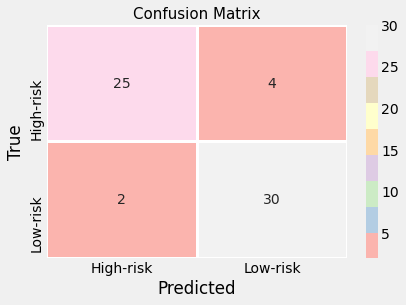

Precision: 0.882 
Recall: 0.938 
F1-Score: 0.909 
Accuracy: 90.164 %
Mean Square Error: 0.098


In [19]:
start = time.time()

model_Log= LogisticRegression(random_state=10)
model_Log.fit(X_train,Y_train)
Y_pred= model_Log.predict(X_test)

end=time.time()

model_Log_time=end-start
model_Log_accuracy=round(accuracy_score(Y_test,Y_pred), 4)*100 # Accuracy

print(f"Execution time of model: {round((model_Log_time),5)} seconds\n")
#Plot and compute metrics
compute(Y_pred,Y_test)



# 02. K-Nearest-Neighbour

Execution time of model: 0.00914 seconds


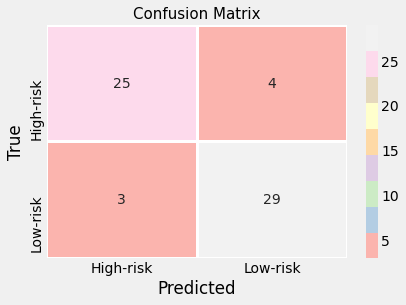

Precision: 0.879 
Recall: 0.906 
F1-Score: 0.892 
Accuracy: 88.525 %
Mean Square Error: 0.115


In [20]:
start=time.time()

model_KNN = KNeighborsClassifier(n_neighbors=15)
model_KNN.fit(X_train,Y_train)
Y_pred = model_KNN.predict(X_test)

end=time.time()

model_KNN_time = end-start
model_KNN_accuracy=round(accuracy_score(Y_test,Y_pred), 4)*100 # Accuracy

print(f"Execution time of model: {round((model_KNN_time),5)} seconds")
#Plot and compute metric
compute(Y_pred,Y_test)



```

```

# 3 => Support Vector Machines

Execution time of model: 0.00616 seconds


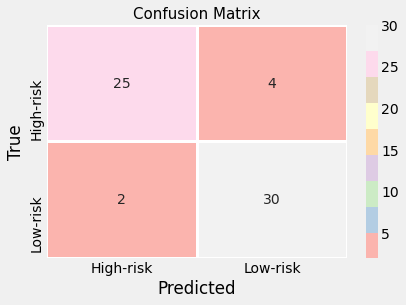

Precision: 0.882 
Recall: 0.938 
F1-Score: 0.909 
Accuracy: 90.164 %
Mean Square Error: 0.098


In [21]:
start=time.time()

model_svm=SVC(kernel="rbf")
model_svm.fit(X_train,Y_train)
Y_pred=model_svm.predict(X_test)

end=time.time()

model_svm_time=end-start
model_svm_accuracy=round(accuracy_score(Y_test,Y_pred), 4)*100 # Accuracy

print(f"Execution time of model: {round((model_svm_time),5)} seconds")
#Plot and compute metric
compute(Y_pred,Y_test)



```

```
# 4 => Decision Tree Classifier


Execution time of model: 0.0031 seconds


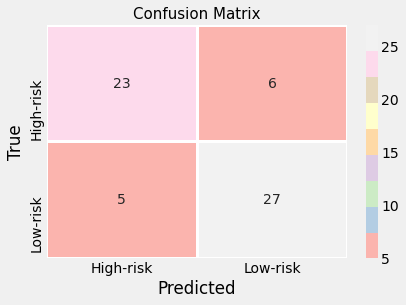

Precision: 0.818 
Recall: 0.844 
F1-Score: 0.831 
Accuracy: 81.967 %
Mean Square Error: 0.18


In [22]:
start=time.time()

model_tree=DecisionTreeClassifier(random_state=10,criterion="gini",max_depth=100)
model_tree.fit(X_train,Y_train)
Y_pred=model_tree.predict(X_test)

end=time.time()

model_tree_time=end-start
model_tree_accuracy=round(accuracy_score(Y_test,Y_pred), 4)*100 # Accuracy

print(f"Execution time of model: {round((model_tree_time),5)} seconds")
#Plot and compute metric
compute(Y_pred,Y_test)



```

```
# 5 => Random Forest Classifier


Execution time of model: 0.47299 seconds


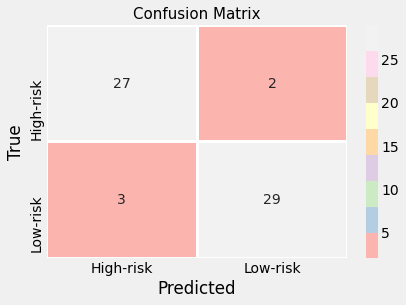

Precision: 0.935 
Recall: 0.906 
F1-Score: 0.921 
Accuracy: 91.803 %
Mean Square Error: 0.082


In [23]:
start=time.time()

model_RF = RandomForestClassifier(n_estimators=300,criterion="gini",random_state=5,max_depth=100)
model_RF.fit(X_train,Y_train)
Y_pred=model_RF.predict(X_test)

end=time.time()

model_RF_time=end-start
model_RF_accuracy=round(accuracy_score(Y_test,Y_pred), 4)*100 # Accuracy

print(f"Execution time of model: {round((model_RF_time),5)} seconds")
#Plot and compute metric
compute(Y_pred,Y_test)



```

```
# 6 => AdaBoost Classifier


Execution time of model: 0.04617 seconds


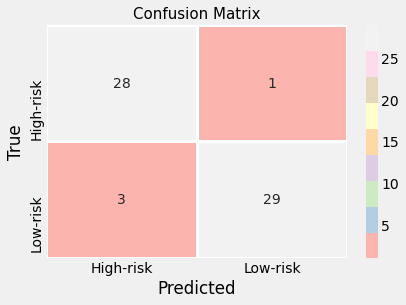

Precision: 0.967 
Recall: 0.906 
F1-Score: 0.935 
Accuracy: 93.443 %
Mean Square Error: 0.066


In [24]:
#Build Model
start=time.time()

model_ADA=AdaBoostClassifier(learning_rate= 0.15,n_estimators= 25)
model_ADA.fit(X_train,Y_train)
Y_pred= model_ADA.predict(X_test)

end=time.time()

model_ADA_time=end-start
model_ADA_accuracy=round(accuracy_score(Y_test,Y_pred), 4)*100 # Accuracy

print(f"Execution time of model: {round((model_ADA_time),5)} seconds")
#Plot and compute metric
compute(Y_pred,Y_test)



```

```
# 7 => Gradient Boosting Classifier


Execution time of model: 0.02081 seconds


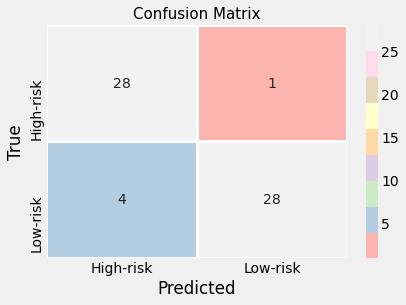

Precision: 0.966 
Recall: 0.875 
F1-Score: 0.918 
Accuracy: 91.803 %
Mean Square Error: 0.082


In [25]:
start=time.time()

model_GB= GradientBoostingClassifier(random_state=10,n_estimators=20,learning_rate=0.29,loss="deviance")
model_GB.fit(X_train,Y_train)
Y_pred= model_GB.predict(X_test)

end=time.time()

model_GB_time=end-start
model_GB_accuracy=round(accuracy_score(Y_test,Y_pred), 4)*100 # Accuracy

print(f"Execution time of model: {round((model_GB_time),5)} seconds")
#Plot and compute metric
compute(Y_pred,Y_test)



```

```
# 8 => XGBoost Classifier


Execution time of model: 0.13227 seconds


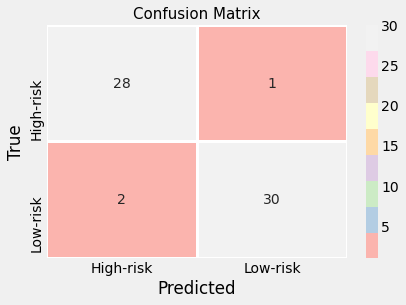

Precision: 0.968 
Recall: 0.938 
F1-Score: 0.952 
Accuracy: 95.082 %
Mean Square Error: 0.049


In [26]:
start=time.time()

model_xgb = XGBClassifier(objective='binary:logistic',learning_rate=0.1,
                          max_depth=1,
                          n_estimators = 50,
                          colsample_bytree = 0.5)
model_xgb.fit(X_train,Y_train)
Y_pred = model_xgb.predict(X_test)

end=time.time()

model_xgb_time=end-start
model_xgb_accuracy=round(accuracy_score(Y_test,Y_pred), 4)*100 # Accuracy

print(f"Execution time of model: {round((model_xgb_time),5)} seconds")
#Plot and compute metric
compute(Y_pred,Y_test)



```
```

# 9 => MLPClassifier

Execution time of model: 0.96024 seconds


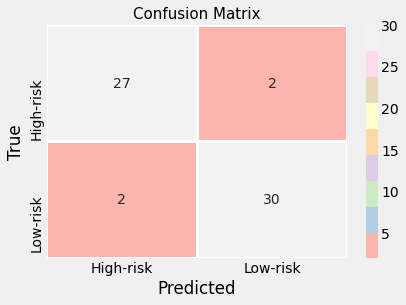

Precision: 0.938 
Recall: 0.938 
F1-Score: 0.938 
Accuracy: 93.443 %
Mean Square Error: 0.066


In [27]:
start=time.time()

model_MLP = MLPClassifier(random_state=48,hidden_layer_sizes=(150,100,50), max_iter=150,activation = 'relu',solver='adam')
model_MLP.fit(X_train, Y_train)
Y_pred=model_MLP.predict(X_test)

end=time.time()

# print(classification_report(y_test, y_pred))
# print(f'ROC AUC score: {roc_auc_score(y_test, y_prob)}')
# print('Accuracy Score: ',accuracy_score(y_test, y_pred))

model_MLP_time=end-start
model_MLP_accuracy=round(accuracy_score(Y_test,Y_pred), 4)*100 # Accuracy

print(f"Execution time of model: {round((model_MLP_time),5)} seconds")
#Plot and compute metric
compute(Y_pred,Y_test)

## Check which state of condition , the model perform the best using the following checkRS() function.

RMSE is lowest at 0.049 for n: [100, 125, 150, 175] 


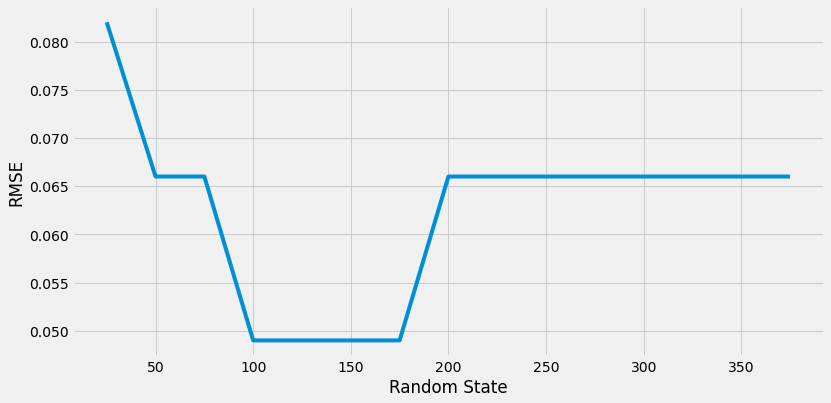

Accuracy is highest at 95.082 % for n: [100, 125, 150, 175] 


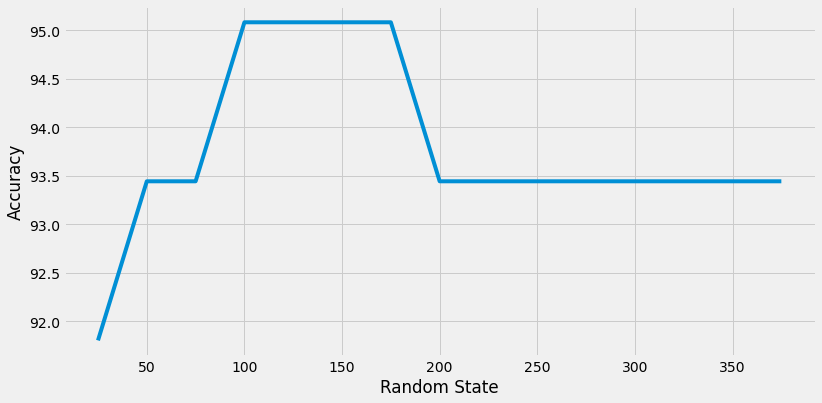

In [28]:
def checkRS():

    mse_dict={}  #Root mean square dictionary
    acc_dict={}  #Accuracy dictionary

    for n in range(25,400,25):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,random_state=65)
        model_MLP = MLPClassifier(random_state=48,hidden_layer_sizes=(150,100,50), max_iter=n,activation = 'relu',solver='adam')
        model_MLP.fit(X_train, Y_train)
        Y_pred=model_MLP.predict(X_test)
        acc=accuracy_score(Y_test,Y_pred)
        mse=mean_squared_error(Y_test,Y_pred)
        mse_dict.update({n:round(mse,3)})
        acc_dict.update({n:round((acc*100),3)})

    #Mean Square Error
    lowest=min(mse_dict.values())
    res = [key for key in mse_dict if mse_dict[key] == lowest]
    mse_list=mse_dict.items()
    k,v = zip(*mse_list) 
    print("RMSE is lowest at {} for n: {} ".format(round((lowest),3),res))

    #Plot RMSE values
    plt.figure(figsize=(12,6))
    #plt.scatter(res,lowest,color="red",lw=5)
    plt.plot(k,v)
    plt.xlabel("Random State")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.show()

    #Accuracy
    highest=max(acc_dict.values())
    res1= [key for key in acc_dict if acc_dict[key] == highest]
    acc_list=acc_dict.items()
    k1,v1=zip(*acc_list)
    print("Accuracy is highest at {} % for n: {} ".format(highest,res1))
    #Plot Accuracy values
    plt.figure(figsize=(12,6))
    #plt.scatter(res1,highest,color="red",lw=5)
    plt.plot(k1,v1)
    plt.xlabel("Random State")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()
    
checkRS()

##RMS - Random Model State. Where RMS is low , there accuracy will be high



```

```



```

```

#Compare Accuracy and Execution Time

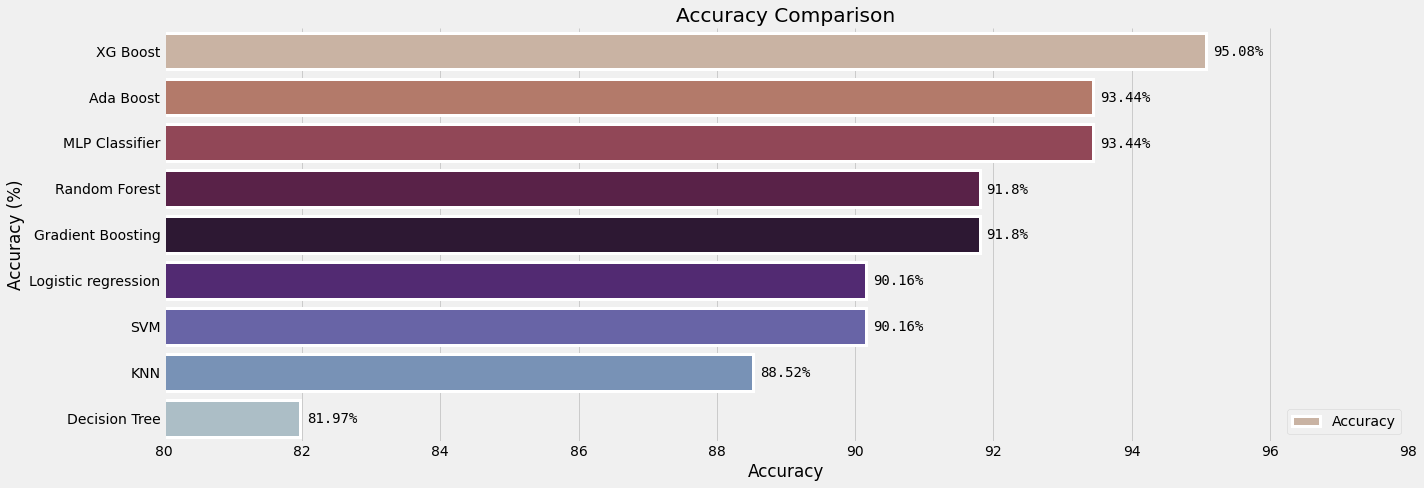

In [29]:
accuracies={"Logistic regression": model_Log_accuracy,
            "KNN": model_KNN_accuracy,
            "SVM": model_svm_accuracy,
            "Decision Tree": model_tree_accuracy,
            "Random Forest": model_RF_accuracy,
            "Ada Boost": model_ADA_accuracy,
            "Gradient Boosting": model_GB_accuracy,
            "XG Boost": model_xgb_accuracy,
            "MLP Classifier": model_MLP_accuracy}

acc_list=accuracies.items()
k,v = zip(*acc_list) 
temp=pd.DataFrame(index=k,data=v,columns=["Accuracy"])
temp.sort_values(by=["Accuracy"],ascending=False,inplace=True)

#Plot accuracy for different models
plt.figure(figsize=(20,7))
ACC=sns.barplot(y=temp.index,x=temp["Accuracy"],label="Accuracy",edgecolor="white",linewidth=3,orient="h",palette="twilight_r")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison")
plt.xlim(80,98)

ACC.spines['left'].set_linewidth(3)
for w in ['right', 'top', 'bottom']:
    ACC.spines[w].set_visible(False)
    
#Write text on barplots
k=0
for ACC in ACC.patches:
    width = ACC.get_width()
    plt.text(width+0.1, (ACC.get_y() + ACC.get_height()-0.3),s="{}%".format(temp["Accuracy"][k]),fontname = 'monospace', fontsize = 14, color = 'black') 
    k+=1
    
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


So clearly, the boosting algorithms have dominated the accuracy when it comes to the model comparison .


*   XGBoost: 95.08% 
*   AdaBoost: 93.44%
*   MLPClassifier: 93.44%
*   Random Forest: 91.8%
*   Gradient Boosting: 91.8%
*   Logistic Regression: 90.16%
*   SVM: 90.16%
*   KNN: 88.52%
*   Decision Tree: 81.97%


















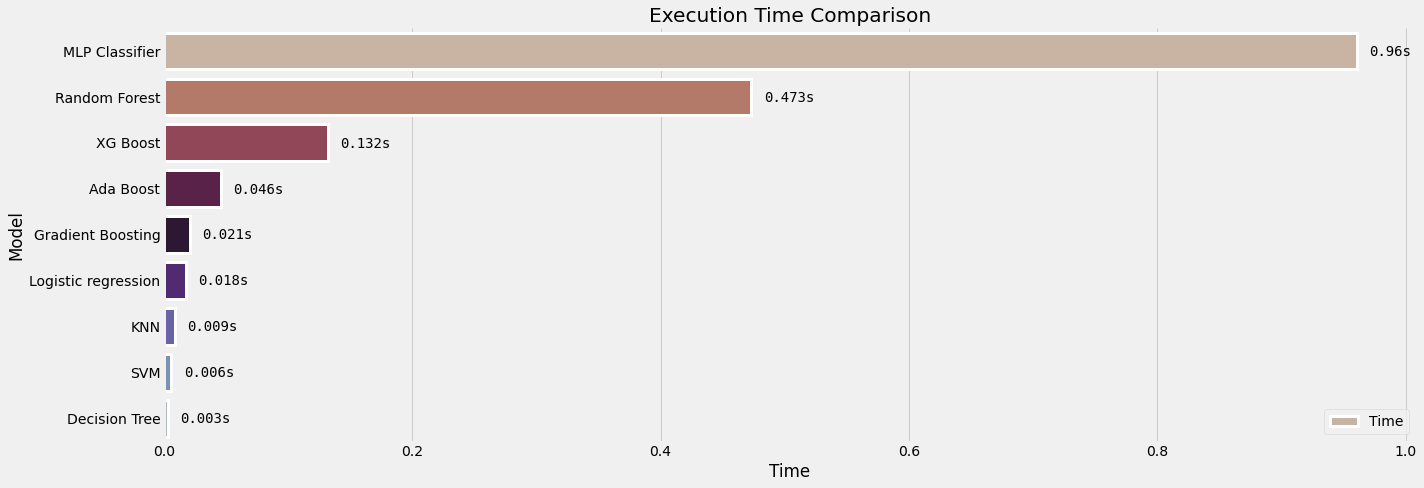

In [30]:
exe_time={"Logistic regression": model_Log_time,
            "KNN": model_KNN_time,
            "SVM": model_svm_time,
            "Decision Tree": model_tree_time,
            "Random Forest": model_RF_time,
            "Ada Boost": model_ADA_time,
            "Gradient Boosting": model_GB_time,
            "XG Boost": model_xgb_time,
            "MLP Classifier": model_MLP_time }

time_list=exe_time.items()
k,v = zip(*time_list) 
temp1=pd.DataFrame(index=k,data=v,columns=["Time"])
temp1.sort_values(by=["Time"],ascending=False,inplace=True)

#Plot accuracy for different models
plt.figure(figsize=(20,7))
ET=sns.barplot(y=temp1.index,x=temp1["Time"],label="Time",edgecolor="white",linewidth=3,orient="h",palette="twilight_r")
plt.ylabel("Model")
plt.title("Execution Time Comparison")
ET.spines['left'].set_linewidth(3)
for w in ['right', 'top', 'bottom']:
    ET.spines[w].set_visible(False)

#Write text on barplots
k=0
for ET in ET.patches:
    width = ET.get_width()
    plt.text(width+0.01, (ET.get_y() + ET.get_height()-0.3),s="{}s".format(round((temp1["Time"][k]),3)),fontname = 'monospace', fontsize = 14, color = 'black') 
    k+=1

plt.legend(loc="lower right")
plt.tight_layout()
plt.show()



```


```

#conclution

01. I started off by understanding the columns of the Heart Attack dataset and performing EDA on the it.
02. The dataset didn't mention which label (0 or 1) stood for which gender, hence we also found that with a little extra research.
03. I then preprocessed the data based on the correlation and outliners.
04. The preprocessed data was used to train 9 ML models who's accuracy and execution time was stored and later plotted to compare the models.